Circular tokamak
===

Based on notes by Alan Wootton
(https://web2.ph.utexas.edu/~iheds/magneticfieldsinatokamak.pdf)

In [19]:
from numpy import *
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate as interpolate
import scipy.special as special

plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

In [20]:
# Geometry choices

# Major radius of geometric center
Rg = 1

# Minor radius
a = 0.2

In [21]:
# Range for plotting

RmRgmin = -0.8
RmRgmax = 0.5
nx = 100

zmin = -0.5
zmax = 0.5
nz = 101

ixtest1 = 50

(X,Z) = meshgrid(linspace(RmRgmin, RmRgmax, nx),
                 linspace(zmin, zmax, nz))

# minor radius
r = sqrt(X**2 + Z**2)

# angle with outboard equator equal to zero
theta = arctan2(Z, X)

Assumed current density profile
--

Toroidal current density as function of $x\equiv r/a$ is
$$
j_\phi=j_{\phi 0}\left(1-x^2\right)^\alpha
$$

Specify exponent $\alpha$ from desired ratio of safety factor:
$$
\alpha=\frac{q(1)}{q(0)}-1
$$

In [22]:
# Safety factor at edge and at magnetic axis
q1 = 10
q0 = 1.1

# Current profile exponent from q ratio
alpha = q1/q0 - 1

print('q0 =', q0)
print('q1 =', q1)
print('alpha = %g' % alpha)




q0 = 1.1
q1 = 10
alpha = 8.09091


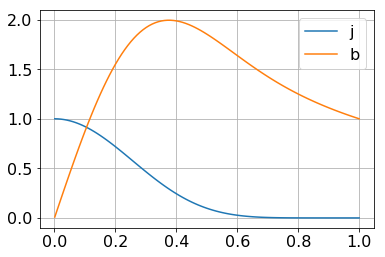

In [23]:
# The normalized functions
fjphi = lambda x: (1 - x**2)**alpha
fbtheta = lambda x: (1 - (1 - x**2)**(1 + alpha))/x

x = linspace(0.001, 1, 101)
plt.plot(x, fjphi(x))
plt.plot(x, fbtheta(x))
plt.legend(('j','b'))
plt.grid()
plt.show()


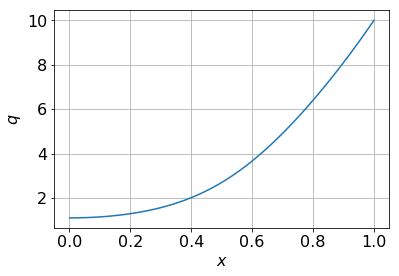

In [24]:
# Plot q profile
q = lambda x: q1*x/fbtheta(x)
x = linspace(0.001, 1, 101)
plt.plot(x, q(x))
plt.grid()
#plt.ylim((0.5,2.5))
plt.xlabel('$x$')
plt.ylabel('$q$')
plt.show()


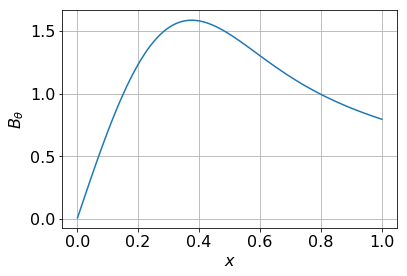

In [25]:
# Plasma current mu0*Ip = 1
mu0Ip = 1

# Current density
mu0jphi0 = mu0Ip*(1 + alpha)/(pi*a**2)

# Poloidal field at the surface
Btheta01 = mu0Ip/(2*pi*a)

Btheta = zeros_like(x)
sel = x > 0

#Btheta[sel] = Btheta01*(1 - (1 - x[sel]**2)**(1 + alpha))/x[sel]
Btheta[sel] = Btheta01*fbtheta(x[sel])


plt.plot(x, Btheta)
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$B_\\theta$')

plt.show()

Next we calculate the inductance per unit length, $l_i$.  For the current profile we have chosen it is given by
$$
l_i=2\int_0^1\left[1-\left(1-x^2\right)^{1+\alpha}\right]^2\,\frac{dx}{x}
$$

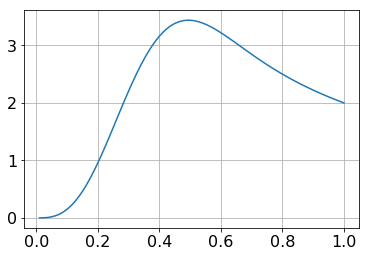

In [26]:
x = linspace(0, 1, 101)
dlidx = lambda x: 2*x*fbtheta(x)**2

plt.plot(x[1:], dlidx(x[1:]))
plt.grid()
plt.show()

li_quadrature = scipy.integrate.trapz(dlidx(x[1:]), x=x[1:])

In [27]:
# Inductance per unit length

# Analytic expression (for the assumed current profile and approximation level)
eulergamma = -special.digamma(1)
li = eulergamma + 2*special.polygamma(0, 2 + alpha) - special.polygamma(0, 3 + 2*alpha)

# Polynomial approximation
li_approx = 0.509619 + 0.462798*alpha - 0.0630876*alpha**2 + 0.00443746*alpha**3

print('li = %g quadrature' % li_quadrature)

print('li = %g analytic' % li)

print('li = %g polynomial approximation' % li_approx)

li = 2.17206 quadrature
li = 2.17208 analytic
li = 2.4745 polynomial approximation


The pressure profile is
$$
p(x)=p_0(0)\left(1-x^2\right)^\gamma
$$
and the poloidal beta is defined by
$$
\beta_I=\frac{2\mu_0 p_0(0)}{(1+\gamma)B_{\theta 0}^2(1)}
$$

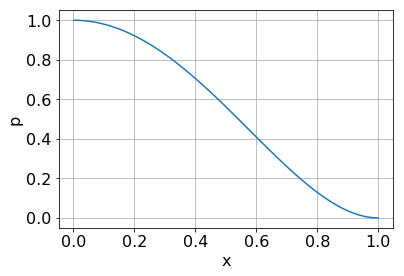

In [28]:
# Pressure

# poloidal beta
betap = 2

# Pressure profile exponent
g = 2

# Plot pressure profile
x = linspace(0.001, 1, 101)
plt.plot(x, (1 - x**2)**g)
plt.grid()
plt.xlabel('x')
plt.ylabel('p')
plt.show()

In [29]:
LAMBDA = (betap + li/2 - 1)

print(LAMBDA)

2.08604058217


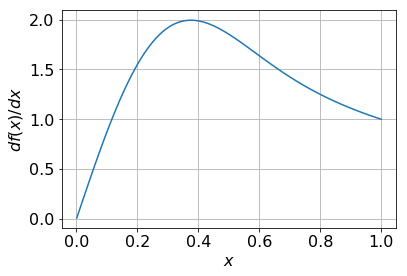

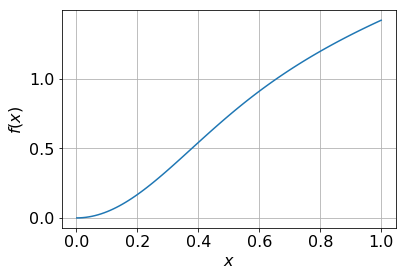

In [30]:
# Determine poloidal flux by integrating Btheta
# Here we define f(x) = integal fbtheta(x) dx

dfdx = zeros_like(x)
sel = x > 0
#dfdx[sel] = (1 - (1 - x[sel]**2)**(1+alpha))/x[sel]
dfdx[sel] = fbtheta(x[sel])

plt.plot(x, dfdx)
plt.grid()
plt.xlabel('$x$', FontSize=16)
plt.ylabel('$df(x)/dx$', FontSize=16)
plt.show()

f = scipy.integrate.cumtrapz(dfdx, x=x, initial=0)
plt.plot(x, f)
plt.grid()
plt.xlabel('$x$', FontSize=16)
plt.ylabel('$f(x)$', FontSize=16)
plt.show()


In [31]:
# Set up psi0(x) function with psi0(1) = 0

psi0spline = interpolate.splrep(x, Btheta01*a*Rg*(f[-1] - f), s=0)

# Poloidal flux function and its derivative, as functions of x=r/a
psi0 = lambda x: interpolate.splev(x, psi0spline)
dpsi0dx = lambda x: interpolate.splev(x, psi0spline, der=1)

print('Poloidal flux:', psi0(0))


Poloidal flux: 0.22586597182572468


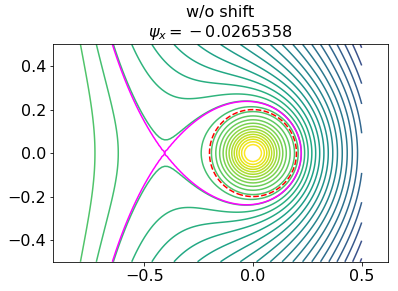

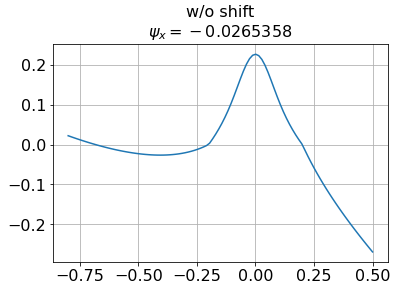

In [32]:
# Poloidal flux psi(R-Rg,Z) outside the minor radius
# Evaluating function everywhere

# Separate plasma and external fluxes (might be some math errors here)
#psip = (Rg/(2*pi))*(log(8*Rg/r) - 2) - (r/(4*pi))*(-log(8*Rg/r)+1-(a/r)**2*(LAMBDA+1/2))*cos(theta)
#psie = -(1/(4*pi))*(-log(8*Rg/a)+LAMBDA-1/2)*r*cos(theta)

# Poloidal flux, shifted to zero at r = a
psi_shift = (Rg/(2*pi))*(log(8*Rg/a)-2)

#psi = (Rg/(2*pi))*(log(8*Rg/r)-2-log(8*Rg/a)+2)-(r/(4*pi))*((1-a**2/r**2)*(LAMBDA+1/2)+log(r/a))*cos(theta)

psi = (Rg/(2*pi))*(log(8*Rg/r)-2)-(r/(4*pi))*((1-a**2/r**2)*(LAMBDA+1/2)+log(r/a))*cos(theta)
psi = psi - psi_shift

sel = r < a
#psi[sel] = interpolate.splev(r[sel]/a, psi0spline, der=0)

psi[sel] = psi0(r[sel]/a)


# Separatrix
psi_sep = psi[ixtest1,X[ixtest1,:]<-a].min()

plt.contour(X, Z, psi, linspace(-0.5, 0.2, 41))
plt.contour(X, Z, r, [a,], colors='red', linestyles='--')
plt.contour(X, Z, psi, [psi_sep,], colors='magenta', linestyles='-')

plt.axis('equal')
plt.title('w/o shift\n$\psi_x=%g$' % psi_sep)
plt.show()

plt.plot(X[ixtest1,:], psi[ixtest1,:])
plt.grid()
plt.title('w/o shift\n$\psi_x=%g$' % psi_sep)

plt.show()


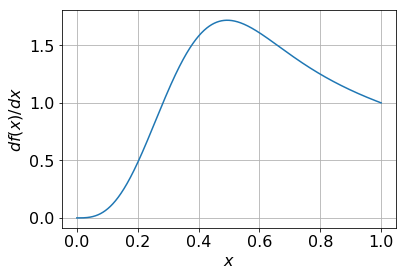

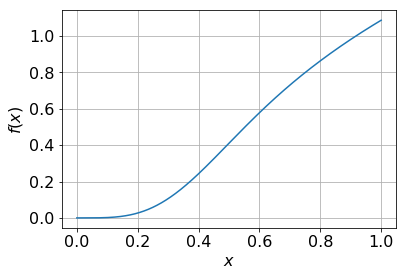

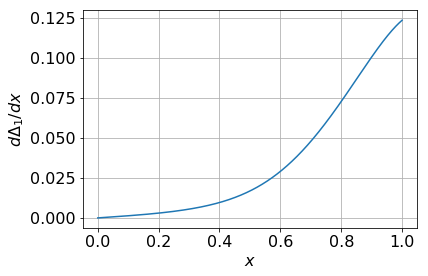

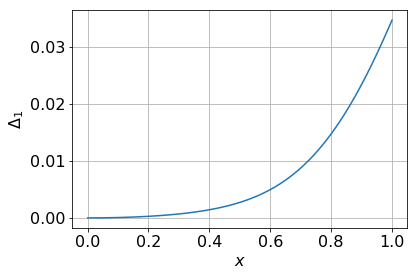

In [33]:
# Shafranov shift function

# f = an integral we need
x = linspace(0, 1, 1000)
dfdx = zeros_like(x)
sel = x > 0
dfdx[sel] = (1 - (1 - x[sel]**2)**(1+alpha))**2/x[sel]

plt.plot(x, dfdx)
plt.grid()
plt.xlabel('$x$', FontSize=16)
plt.ylabel('$df(x)/dx$', FontSize=16)
plt.show()

f = scipy.integrate.cumtrapz(dfdx, x=x, initial=0)
plt.plot(x, f)
plt.grid()
plt.xlabel('$x$', FontSize=16)
plt.ylabel('$f(x)$', FontSize=16)
plt.show()

dDelta_1dx = zeros_like(x)
sel = x > 0
dDelta_1dx[sel] = -((a/Rg)*a/2)*(2*x[sel]/(1-(1-x[sel]**2)**(1+alpha))**2)*(
    betap*(g+1)*x[sel]**2*(1-x[sel]**2)**g-betap*(1-(1-x[sel]**2)**(g+1))-f[sel])

plt.plot(x, dDelta_1dx)
plt.xlabel('$x$', FontSize=16)
plt.ylabel('$d\Delta_1/dx$', FontSize=16)
plt.grid()

plt.show()

Delta_1 = scipy.integrate.cumtrapz(dDelta_1dx, x=x, initial=0)
plt.plot(x, Delta_1)
plt.xlabel('$x$', FontSize=16)
plt.ylabel('$\Delta_1$', FontSize=16)
plt.grid()

plt.show()


In [34]:
# The Shafranov shift
Delta_s = ((a/Rg)*a/2)*((1 + 2*alpha/9 + alpha**2/72)/4 +
                       (betap*g*(g+1)/(4*(1+alpha)**2))*(
                       2 + 11*alpha/9 + 5*alpha**2/18 + (g-1)*(g-6)/6
                       - 4*alpha*(g-1)/9))

print('Shafranov shift')
print('simple    %g' % Delta_s)
print('numerical %g' % Delta_1[-1])


Shafranov shift
simple    0.0372743
numerical 0.0346762


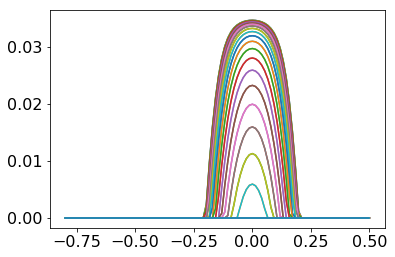

In [35]:
# Shafranov shift spline
Delta_1_spline = interpolate.splrep(x, Delta_1[-1] - Delta_1, s=0)

Delta_1 = lambda x: interpolate.splev(x, Delta_1_spline, der=0)

# Onto the grid
sel = r < a
grid_Delta_1 = zeros_like(r)
grid_Delta_1[sel] = Delta_1(r[sel]/a)


plt.plot(X.T, grid_Delta_1.T)
plt.show()

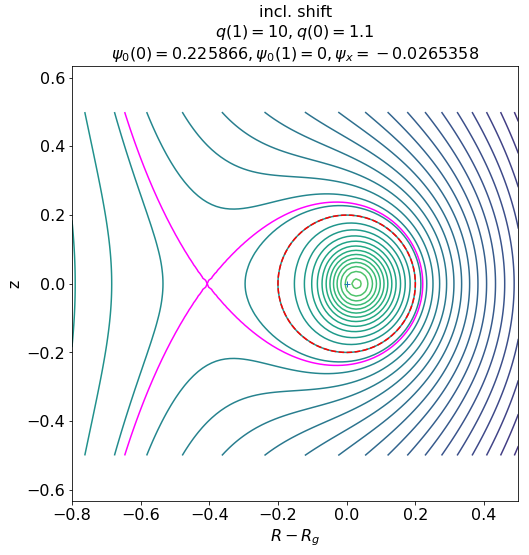

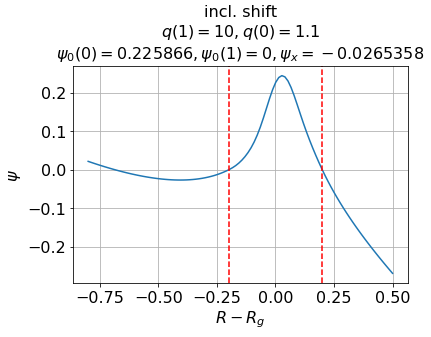

In [41]:
# Replace interior poloidal flux function with Shafranov shifted one
sel = r < a
psi[sel] = psi0(r[sel]/a) - grid_Delta_1[sel]*cos(theta[sel])*dpsi0dx(r[sel]/a)/a

# Replot
plt.figure(figsize=(8,8))
plt.contour(X, Z, psi, linspace(-0.5, 0.5, 51))
plt.contour(X, Z, r, [a,], colors='red', linestyles='--')
plt.contour(X, Z, psi, [psi_sep,], colors='magenta', linestyles='-')
plt.plot(0, 0, '+')


plt.axis('equal')
plt.title('incl. shift\n$q(1)=%g,q(0)=%g$\n$\psi_{0}(0)=%g,\psi_{0}(1)=%g,\psi_x=%g$' % 
          (q1, q0, psi0(0), psi0(1), psi_sep))

plt.xlabel('$R - R_g$')
plt.ylabel('z')
plt.show()

plt.plot(X[ixtest1,:], psi[ixtest1,:])
plt.grid()
plt.axvline(a, color='r',ls='--')
plt.axvline(-a, color='r',ls='--')
plt.title('incl. shift\n$q(1)=%g,q(0)=%g$\n$\psi_{0}(0)=%g,\psi_{0}(1)=%g,\psi_x=%g$' % 
          (q1, q0, psi0(0), psi0(1), psi_sep))

plt.xlabel('$R - R_g$')
plt.ylabel('$\psi$')
plt.show()



Discussion
--

Including the Shafranov shift makes the poloidal flux smooth at the plasma-vacuum interface.

n.b., For equilibrium calculations vacuum simply means where the current density is zero.  For ideal MHD stability calculations the vacuum is assumed to maintain zero current density when the plasma region moves.  Thus the so-called vacuum region could be a true vacuum or it could simply be a plasma with high resistivity.  Most MHD codes do not handle true vacuum.

